# Notebook to test and illustrate FAST algorithm

In [1]:
%load_ext autoreload
%autoreload 2

### Tests on single image

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import fast

In [98]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

In [99]:
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
keypoints = fast.detect(np.asarray(gray, dtype="int32"), threshold=15, step=5)

In [92]:
keypoints.shape

(1148, 2)

#### FAST returns points if its neighboring pixels are different.
It should not return key points on smooth walls (because all points are similar).
It should mainly return points on edges with strong color change (clothes-background, color change on the dog, leaves, grass, etc.).

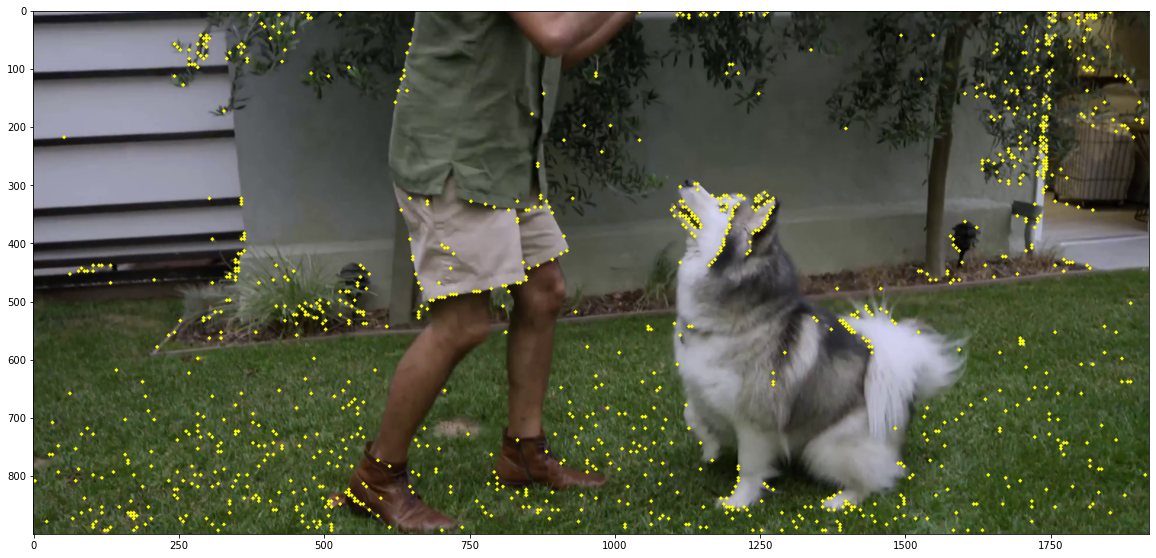

In [93]:
img_with_kp = fast.draw(frame, keypoints)
#cv2.imwrite("imgs/person_dog_kp_detector.png", img_with_kp)

fig=plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))

### Test on video

In [9]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

START_IDX = 60
END_IDX = 210
IDX = 0

ret, frame = cap.read()
result_gif = 'imgs/person_dog_kp_detector.gif'

imgs = []
skip = 3

while ret:
    if IDX % skip != 0:
        ret, frame = cap.read()
        IDX += 1
        continue
    if START_IDX <= IDX < END_IDX:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        keypoints = fast.detect(np.asarray(gray, dtype="int32"), threshold=15, step=5)
        img_with_kp = fast.draw(frame, keypoints)
        imgs.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    elif IDX >= END_IDX:
        break
    ret, frame = cap.read()
    IDX += 1
    print(f'IDX={IDX}', end='\r')

imgs[0].save(result_gif, format='GIF',
             append_images=imgs[1:],
             save_all=True, loop=0)

cap.release()
cv2.destroyAllWindows()

## Use a kernel instead of dictionary of positions

In [159]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

In [160]:
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
keypoints = fast.detect(np.asarray(gray, dtype="int32"), threshold=15, step=5)

In [161]:
keypoint = keypoints[100]

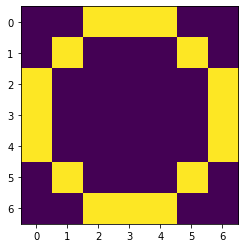

In [162]:
kernel = np.array(
[
    [-1, -1,  1,  1,  1, -1, -1],
    [-1,  1, -1, -1, -1,  1, -1],
    [ 1, -1, -1, -1, -1, -1,  1],
    [ 1, -1, -1, -1, -1, -1,  1],
    [ 1, -1, -1, -1, -1, -1,  1],
    [-1,  1, -1, -1, -1,  1, -1],
    [-1, -1,  1,  1,  1, -1, -1],
]
)
plt.imshow(kernel)

(7, 7)
[[75 92 93 80 70 61 53]
 [66 82 88 83 67 52 45]
 [61 74 86 86 72 51 40]
 [54 57 71 86 75 60 48]
 [52 50 57 74 79 72 58]
 [52 47 54 61 74 79 67]
 [51 43 43 45 59 75 73]]


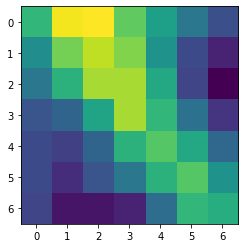

In [164]:
pixel_value = gray[keypoint[0], keypoint[1]]
patch = gray[keypoint[0]-3:keypoint[0]+4, keypoint[1]-3:keypoint[1]+4]
print(patch.shape)
print(patch)
plt.imshow(patch)

[[-75 -92  93  80  70 -61 -53]
 [-66  82 -88 -83 -67  52 -45]
 [ 61 -74 -86 -86 -72 -51  40]
 [ 54 -57 -71 -86 -75 -60  48]
 [ 52 -50 -57 -74 -79 -72  58]
 [-52  47 -54 -61 -74  79 -67]
 [-51 -43  43  45  59 -75 -73]]


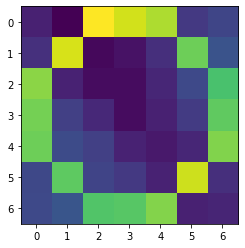

In [165]:
kernel_applied = np.multiply(patch, kernel)
print(kernel_applied)
plt.imshow(kernel_applied)

In [167]:
threshold = 15
lower_bound = pixel_value - threshold
higher_bound = pixel_value + threshold

In [168]:
np.where((kernel_applied >= 0) & ((kernel_applied >= higher_bound) | (kernel_applied <= lower_bound)))[0].shape[0]

12

## Test adaptative threshold single image

In [3]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

In [4]:
for i in range(1):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [261]:
nb_keypoints = 500
for i in range(15):
    keypoints = fast.detect_with_adaptive_threshold(
        gray, nb_keypoints, N=12, step=5, epsilon=nb_keypoints*0.1,
        percentage=0.10, init_threshold=None)
    print("Number of keypoints:", keypoints.shape[0])
    print("New threshold:", fast.detect_with_adaptive_threshold.threshold)

Number of keypoints: 91
New threshold: 26
Number of keypoints: 127
New threshold: 24
Number of keypoints: 173
New threshold: 22
Number of keypoints: 230
New threshold: 20
Number of keypoints: 326
New threshold: 18
Number of keypoints: 432
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17
Number of keypoints: 504
New threshold: 17


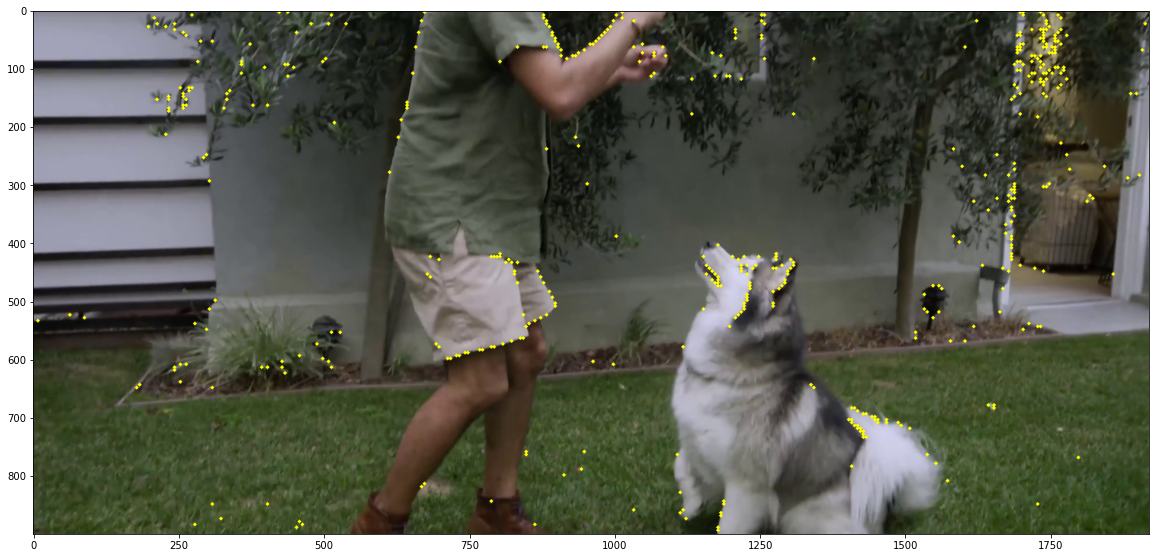

In [262]:
img_with_kp = fast.draw(frame, keypoints)
#cv2.imwrite("imgs/person_dog_kp_detector.png", img_with_kp)

fig=plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))

## Test adaptative threshold on video

In [4]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

START_IDX = 60
END_IDX = 210
IDX = 0

ret, frame = cap.read()
result_gif = 'imgs/person_dog_kp_detector_dyn_threshold.gif'

imgs = []
skip = 3
nb_keypoints = 1000

while ret:
    if IDX % skip != 0:
        ret, frame = cap.read()
        IDX += 1
        continue
    if START_IDX <= IDX < END_IDX:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        keypoints = fast.detect_with_dynamic_threshold(gray, nb_keypoints, N=12, step=5, epsilon=nb_keypoints*0.1,
                                                   percentage=0.10, init_threshold=None)
        img_with_kp = fast.draw(frame, keypoints)
        imgs.append(Image.fromarray(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)))
    elif IDX >= END_IDX:
        break
    ret, frame = cap.read()
    IDX += 1
    print(f'IDX={IDX}', end='\r')

imgs[0].save(result_gif, format='GIF',
             append_images=imgs[1:],
             save_all=True, loop=0)

cap.release()
cv2.destroyAllWindows()

### test grid on a single image

In [3]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

In [46]:
for i in range(5):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [50]:
nb_keypoints = 1000
cols = 4
rows = 3
for i in range(1):
    keypoints = fast.detect_with_adaptive_threshold_and_grid(
        gray, nb_keypoints, N=12, step=5, epsilon=nb_keypoints*0.1,
        percentage=0.10, init_thresholds=[20 for _ in range(cols*rows)], rows=rows, cols=cols)
    print("Number of keypoints:", fast.detect_with_adaptive_threshold_and_grid.nb_keypoints_per_cell)
    print("New thresholds:", fast.detect_with_adaptive_threshold_and_grid.thresholds)

Number of keypoints: [48, 23, 58, 162, 36, 33, 51, 14, 44, 36, 22, 57]
New thresholds: [18, 18, 18, 22, 18, 18, 18, 18, 18, 18, 18, 18]


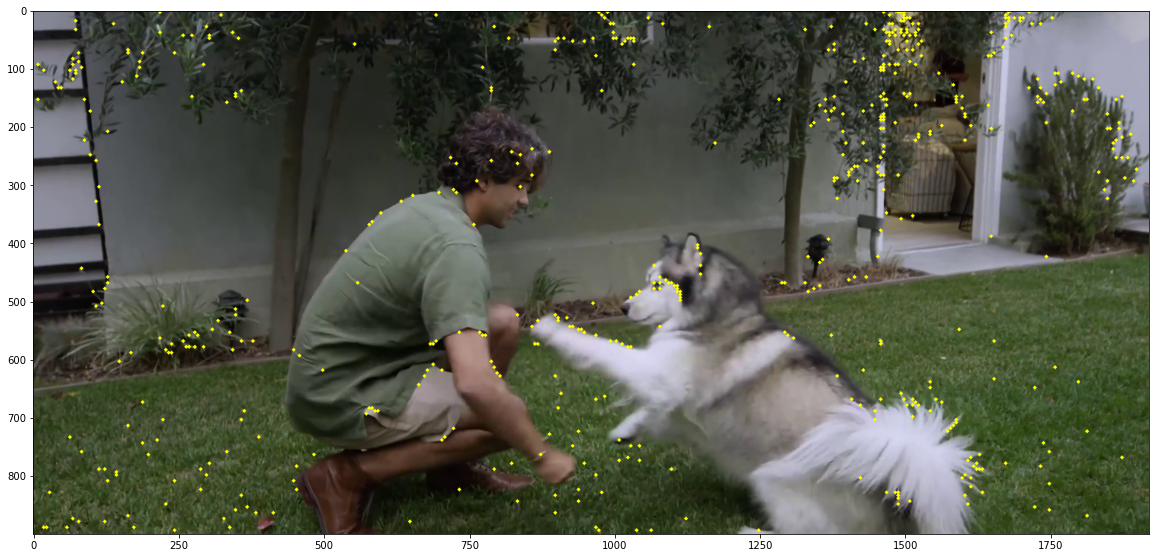

In [51]:
img_with_kp = fast.draw(frame, keypoints)
#cv2.imwrite("imgs/person_dog_kp_detector.png", img_with_kp)

fig=plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))

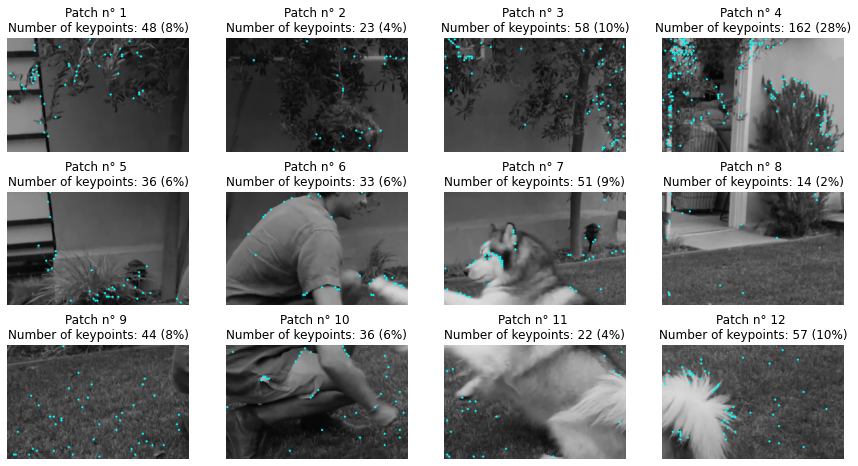

In [57]:
fig = plt.figure(figsize=(15, 8))
for i, (patch, keypoints_per_cell) in enumerate(zip(
        fast.detect_with_adaptive_threshold_and_grid.patches,
        fast.detect_with_adaptive_threshold_and_grid.keypoints_per_cell)):
    fig.add_subplot(rows, cols, i+1)
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    patch_with_kp = fast.draw(patch_rgb, keypoints_per_cell)
    plt.axis('off')
    plt.title(f"Patch n° {i+1} \nNumber of keypoints: {keypoints_per_cell.shape[0]} ({round(keypoints_per_cell.shape[0]/keypoints.shape[0]*100)}%)")
    plt.imshow(patch_with_kp)
plt.show()